
# 📈 Forecasting Iowa Liquor Sales

![Iowa Liquor Sales](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR4n-jPW98Rw94a1TcaUgawZdTcbv93U2Hgcw&s)


## 📚 Function Definitions:

- **`create_data_table`**: Creates a table with the top-selling items within the specified date range.
- **`create_arima_model`**: Creates an ARIMA_PLUS model.
- **`forecast_model`**: Generates forecasts using the created ARIMA model.
- **`evaluate_model`**: Evaluates the forecast model using MAE, MAPE, MSE, RMSE, and SMAPE.
- **`plot_historical_and_forecast`**: Plots historical and forecasted data.
- **`test_stationarity`**: Tests the stationarity of a time series using the Augmented Dickey-Fuller test.
- **`create_and_forecast_prophet`**: Creates and forecasts using Prophet with hyperparameter tuning.
- **`tune_prophet_model`**: Tunes Prophet hyperparameters and finds the best model.
- **`create_and_train_arima_model`**: Combines the steps to create the training data table and train the ARIMA model.
- **`create_and_insert_forecast_data`**: Inserts the forecast data into a table, evaluates it, and exports it to Google Cloud Storage.

## 🛠️ Workflow Execution:

1. 🗂️ Create the training and test data tables using create_data_table (or within create_and_train_arima_model).
2. 🔍 Create the ARIMA model using create_arima_model (or within create_and_train_arima_model).
3. 📊 Forecast future values using the ARIMA model with forecast_model (or within create_and_insert_forecast_data).
4. 📜 Fetch historical and actual data for comparison.
5. 🧪 Test stationarity for each item's total amount sold using test_stationarity.
6. 📈 Evaluate the ARIMA model using evaluate_model.
7. 🖼️ Plot the historical and forecasted data with plot_historical_and_forecast.
8. 🎯 Tune and forecast using Prophet with the best hyperparameters using create_and_forecast_prophet and tune_prophet_model.
9. 📊 Evaluate the Prophet model using evaluate_model.
10. 📤 Export the forecast data to Google Cloud Storage using export_forecast_data (or within create_and_insert_forecast_data).

In [14]:
# -*- coding: utf-8 -*-

## Install additional packages

!pip install --quiet google-cloud-bigquery pandas-gbq  scikit-learn matplotlib statsmodels prophet scipy

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\jarau\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\cmdstan-2.33.1\\stan\\lib\\stan_math\\lib\\tbb_2020.3\\include\\tbb\\internal\\_deprecated_header_message_guard.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\jarau\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [10]:
!gcloud auth application-default login

'gcloud' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


In [ ]:
dataset_id = "bqmlforecast" # @param {type:"string"}
PROJECT_ID = "bqmlproject"  # @param {type:"string"}
LOCATION = "US"  # @param {type:"string"}
ARIMA_PARAMS = {
    "TRAININGDATA_STARTDATE": "2021-01-01",
    "TRAININGDATA_ENDDATE": "2024-05-31",
    "TESTDATA_STARTDATE": "2024-06-01",
    "TESTDATA_ENDDATE": "2024-06-30"
}

In [ ]:

### Set Google Cloud project information"""

"""### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.
"""

!gcloud config set project $PROJECT_ID

BUCKET_URI = f"gs://your-bucket-name-{PROJECT_ID}"

"""**If your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket."""

! gsutil mb -l $LOCATION $BUCKET_URI
!bq mk --location=$REGION --dataset $PROJECT_ID:bqmlforecast


Updated property [core/project].
Creating gs://your-bucket-name-bqmlproject/...
BigQuery error in mk operation: Dataset 'bqmlproject:bqmlforecast' already exists.


In [ ]:
##**Load the required libraries.**
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.cloud.bigquery import Client
from sklearn.metrics import (mean_absolute_error, mean_absolute_percentage_error, mean_squared_error)
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def create_data_table(client, project_id, dataset_id, table_name, start_date, end_date, limit=3):
    """
    Creates or replaces a data table in BigQuery containing top-selling items within a specified date range.

    Parameters
    ----------
    client : bigquery.Client
        The BigQuery client.
    project_id : str
        The Google Cloud project ID.
    dataset_id : str
        The BigQuery dataset ID.
    table_name : str
        The name of the table to create or replace.
    start_date : str
        The start date for filtering data (format: 'YYYY-MM-DD').
    end_date : str
        The end date for filtering data (format: 'YYYY-MM-DD').
    limit : int, optional
        The number of top-selling items to include (default is 3).
    """
    query = f"""
  CREATE OR REPLACE TABLE `{dataset_id}.{table_name}` AS (
    WITH topsellingitems AS (
        SELECT
            item_description,
            COUNT(item_description) AS cnt_transactions
        FROM
            `bigquery-public-data.iowa_liquor_sales.sales`
        GROUP BY
            item_description
        ORDER BY
            cnt_transactions DESC
        LIMIT {limit}  -- Top N items
    ),
    sales_data AS (
        SELECT
            date,
            item_description AS item_name,
            SUM(bottles_sold) AS total_amount_sold,
            AVG(SUM(bottles_sold)) OVER (PARTITION BY item_description ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS rolling_avg_7days,  -- 7-day rolling average
            EXTRACT(DAYOFWEEK FROM date) AS day_of_week,
            CASE
                WHEN EXTRACT(DAYOFWEEK FROM date) IN (1, 7) THEN 1  -- 1=Sunday, 7=Saturday
                ELSE 0
            END AS is_weekend
        FROM
            `bigquery-public-data.iowa_liquor_sales.sales`
        WHERE
            date BETWEEN @START_DATE AND @END_DATE
            AND item_description IN (SELECT item_description FROM topsellingitems)
        GROUP BY
            date, item_name
    )
    SELECT
        date,
        item_name,
        total_amount_sold,
        rolling_avg_7days,
        day_of_week,
        is_weekend
    FROM
        sales_data);
    """
    job_config = bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter("START_DATE", "STRING", start_date),
            bigquery.ScalarQueryParameter("END_DATE", "STRING", end_date),
        ]
    )
    job = client.query(query, job_config=job_config)
    print(f"Table {dataset_id}.{table_name} created.")

def create_arima_model(client, dataset_id, model_name):
    """
    Creates or replaces an ARIMA model in BigQuery.

    Parameters
    ----------
    client : bigquery.Client
        The BigQuery client.
    dataset_id : str
        The BigQuery dataset ID.
    model_name : str
        The name of the model to create or replace.
    """
    query = f"""
    CREATE OR REPLACE MODEL {dataset_id}.{model_name}
    OPTIONS(
      MODEL_TYPE='ARIMA_PLUS',
      TIME_SERIES_TIMESTAMP_COL='date',
      TIME_SERIES_DATA_COL='total_amount_sold',
      TIME_SERIES_ID_COL='item_name',
      HOLIDAY_REGION='US',
      AUTO_ARIMA=TRUE,
      DATA_FREQUENCY='DAILY',
      ADJUST_STEP_CHANGES=TRUE
    ) AS
    SELECT
        date,
        item_name,
        total_amount_sold
    FROM
      {dataset_id}.training_data
    """
    job = client.query(query)
    print(f"Model {dataset_id}.{model_name} created.")

def forecast_model(client, dataset_id, model_name, horizon=30, confidence_level=0.9):
    """
    Generates forecasts using an ARIMA model in BigQuery.

    Parameters
    ----------
    client : bigquery.Client
        The BigQuery client.
    dataset_id : str
        The BigQuery dataset ID.
    model_name : str
        The name of the model to use for forecasting.
    horizon : int, optional
        The number of values to forecast (default is 30).
    confidence_level : float, optional
        The confidence level for the forecast (default is 0.9).

    Returns
    -------
    pandas.DataFrame
        A DataFrame containing the forecasted data.
    """
    query = f'''
        SELECT
          *
        FROM
          ML.FORECAST(MODEL {dataset_id}.{model_name},
                      STRUCT({horizon} AS horizon,
                              {confidence_level} AS confidence_level)
                     )
    '''
    job = client.query(query)
    forecast_df = job.to_dataframe()
    return forecast_df

def evaluate_model(dfactual, dfforecast):
    """
    Evaluates the accuracy of a forecast model.

    Parameters
    ----------
    dfactual : pandas.DataFrame
        The actual data.
    dfforecast : pandas.DataFrame
        The forecasted data.

    Returns
    -------
    pandas.DataFrame
        A DataFrame containing the error metrics for each item.
    """
    dfactual['date'] = pd.to_datetime(dfactual['date']).dt.date
    if 'forecast_timestamp' in dfforecast.columns:
        dfforecast['date'] = pd.to_datetime(dfforecast['forecast_timestamp']).dt.date
    else:
        dfforecast['date'] = pd.to_datetime(dfforecast['date']).dt.date

    item_list = dfactual['item_name'].unique()
    errors = {"item_name": [], "MAE": [], "MAPE": [], "MSE": [], "RMSE": [], "SMAPE": []}

    for i in item_list:
        actual_values = dfactual[dfactual["item_name"] == i].set_index('date')
        forecast_values = dfforecast[dfforecast["item_name"] == i].set_index('date')

        aligned = actual_values.join(forecast_values, how='inner', lsuffix='_actual', rsuffix='_forecast')

        if 'forecast_value' in aligned.columns:
            yhat = 'forecast_value'
            y = 'total_amount_sold'
        else:
            yhat = 'total_amount_sold_forecast'
            y = 'total_amount_sold_actual'

        mae = mean_absolute_error(aligned[y], aligned[yhat])
        mape = (abs((aligned[y] - aligned[yhat]) / aligned[y]).mean()) * 100
        mse = mean_squared_error(aligned[y], aligned[yhat], squared=True)
        rmse = mean_squared_error(aligned[y], aligned[yhat], squared=False)
        smape = (abs(aligned[y] - aligned[yhat]) / (abs(aligned[y]) + abs(aligned[yhat])) * 2).mean() * 100

        errors["item_name"].append(i)
        errors["MAE"].append(mae)
        errors["MAPE"].append(mape)
        errors["MSE"].append(mse)
        errors["RMSE"].append(rmse)
        errors["SMAPE"].append(smape)

    errors_df = pd.DataFrame(errors)
    return errors_df

def plot_historical_and_forecast(input_timeseries, timestamp_col_name, data_col_name, forecast_output=None, actual=None, title=None, plotstartdate=None):
    """
    Plots historical data along with forecasted and actual data.

    Parameters
    ----------
    input_timeseries : pandas.DataFrame
        The input historical data.
    timestamp_col_name : str
        The name of the timestamp column.
    data_col_name : str
        The name of the data column.
    forecast_output : pandas.DataFrame, optional
        The forecasted data (default is None).
    actual : pandas.DataFrame, optional
        The actual data (default is None).
    title : str, optional
        The title of the plot (default is None).
    plotstartdate : str, optional
        The start date for plotting data (default is None).
    """
    if plotstartdate:
        input_timeseries[timestamp_col_name] = pd.to_datetime(input_timeseries[timestamp_col_name])
        input_timeseries = input_timeseries[input_timeseries[timestamp_col_name] >= pd.to_datetime(plotstartdate)]

    input_timeseries = input_timeseries.sort_values(timestamp_col_name)

    plt.figure(figsize=(20, 6))
    plt.plot(input_timeseries[timestamp_col_name], input_timeseries[data_col_name], label='Historical')
    plt.xlabel(timestamp_col_name)
    plt.ylabel(data_col_name)

    if forecast_output is not None:
        forecast_output = forecast_output.sort_values('forecast_timestamp')
        forecast_output['forecast_timestamp'] = pd.to_datetime(forecast_output['forecast_timestamp'])
        x_data = forecast_output['forecast_timestamp']
        y_data = forecast_output['forecast_value']
        confidence_level = forecast_output['confidence_level'].iloc[0] * 100
        low_CI = forecast_output['confidence_interval_lower_bound']
        upper_CI = forecast_output['confidence_interval_upper_bound']
        plt.plot(x_data, y_data, alpha=1, label='Forecast', linestyle='--')
        plt.fill_between(x_data, low_CI, upper_CI, color='#539caf', alpha=0.4, label=f'{confidence_level} confidence interval')

    if actual is not None:
        actual = actual.sort_values(timestamp_col_name)
        plt.plot(actual[timestamp_col_name], actual[data_col_name], label='Actual', linestyle='--')

    plt.title(f'{title}', fontsize=16)
    plt.legend(loc='upper center', prop={'size': 16})

def test_stationarity(timeseries):
    """
    Tests the stationarity of a time series using the Dickey-Fuller test.

    Parameters
    ----------
    timeseries : pandas.Series
        The time series data to test.

    Returns
    -------
    None
    """
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)
    if dfoutput['p-value'] < 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is not stationary.")

def plot_historical_and_forecastprophet(input_timeseries, timestamp_col_name, data_col_name, forecast_output=None, actual=None, title=None, plotstartdate=None):
    """
    Plots historical data along with forecasted and actual data.

    Parameters
    ----------
    input_timeseries : pandas.DataFrame
        The input historical data.
    timestamp_col_name : str
        The name of the timestamp column.
    data_col_name : str
        The name of the data column.
    forecast_output : pandas.DataFrame, optional
        The forecasted data (default is None).
    actual : pandas.DataFrame, optional
        The actual data (default is None).
    title : str, optional
        The title of the plot (default is None).
    plotstartdate : str, optional
        The start date for plotting data (default is None).
    """
    if plotstartdate:
        input_timeseries[timestamp_col_name] = pd.to_datetime(input_timeseries[timestamp_col_name])
        input_timeseries = input_timeseries[input_timeseries[timestamp_col_name] >= pd.to_datetime(plotstartdate)]

    input_timeseries = input_timeseries.sort_values(timestamp_col_name)


    plt.figure(figsize=(20, 6))
    plt.plot(input_timeseries[timestamp_col_name], input_timeseries[data_col_name], label='Historical', linewidth=1)
    plt.xlabel(timestamp_col_name)
    plt.ylabel(data_col_name)

    if forecast_output is not None:
        forecast_output = forecast_output.sort_values('ds')
        forecast_output['ds'] = pd.to_datetime(forecast_output['ds'])

        forecast_output = forecast_output[(forecast_output['ds'] >= pd.to_datetime(actual.date.min())) &
                                          (forecast_output['ds'] <= pd.to_datetime(actual.date.max()))]
        x_data = forecast_output['ds']
        y_data = forecast_output['yhat']
        low_CI = forecast_output['yhat_lower']
        upper_CI = forecast_output['yhat_upper']

        plt.plot(x_data, y_data, alpha=1, label='Forecast', linestyle='--', color='orange', linewidth=1)
        plt.fill_between(x_data, low_CI, upper_CI, color='#539caf', alpha=0.4, label='90.0 confidence interval')

    if actual is not None:
        actual = actual.sort_values(timestamp_col_name)
        plt.plot(actual[timestamp_col_name], actual[data_col_name], label='Actual', linestyle='--', color='green', linewidth=1)

    plt.title(f'{title}', fontsize=16)
    plt.legend(loc='upper center', prop={'size': 16})
    plt.show()

def evaluate_profetmodel(dfactual, dfforecast):
    """
    Evaluates the accuracy of a forecast model using actual and forecasted data.

    Parameters
    ----------
    dfactual : pandas.DataFrame
        The actual data.
    dfforecast : pandas.DataFrame
        The forecasted data.

    Returns
    -------
    pandas.DataFrame
        A DataFrame containing the error metrics for each item.
    """
    dfactual['date'] = pd.to_datetime(dfactual['date']).dt.date
    dfforecast['ds'] = pd.to_datetime(dfforecast['ds']).dt.date

    item_list = dfactual['item_name'].unique()
    errors = {"item_name": [], "MAE": [], "MAPE": [], "MSE": [], "RMSE": [], "SMAPE": []}

    for i in item_list:
        actual_values = dfactual[dfactual["item_name"] == i].set_index('date')
        forecast_values = dfforecast.set_index('ds')

        aligned = actual_values.join(forecast_values, how='inner', lsuffix='_actual', rsuffix='_forecast')

        mae = mean_absolute_error(aligned['total_amount_sold'], aligned['yhat'])
        mape = (abs((aligned['total_amount_sold'] - aligned['yhat']) / aligned['total_amount_sold']).mean()) * 100
        mse = mean_squared_error(aligned['total_amount_sold'], aligned['yhat'], squared=True)
        rmse = mean_squared_error(aligned['total_amount_sold'], aligned['yhat'], squared=False)
        smape = (abs(aligned['total_amount_sold'] - aligned['yhat']) / (abs(aligned['total_amount_sold']) + abs(aligned['yhat'])) * 2).mean() * 100

        errors["item_name"].append(i)
        errors["MAE"].append(mae)
        errors["MAPE"].append(mape)
        errors["MSE"].append(mse)
        errors["RMSE"].append(rmse)
        errors["SMAPE"].append(smape)

    errors_df = pd.DataFrame(errors)
    return errors_df

def create_and_forecast_prophet(data, forecast_period=30, changepoint_prior_scale=0.05, seasonality_mode='additive', seasonality_prior_scale=10.0, interval_width=0.90):
    """
    Creates and forecasts using the Prophet model with specified hyperparameters.

    Parameters
    ----------
    data : pandas.DataFrame
        The input data for the Prophet model.
    forecast_period : int, optional
        The number of periods to forecast (default is 30).
    changepoint_prior_scale : float, optional
        The changepoint prior scale for the Prophet model (default is 0.05).
    seasonality_mode : str, optional
        The seasonality mode for the Prophet model (default is 'additive').
    seasonality_prior_scale : float, optional
        The seasonality prior scale for the Prophet model (default is 10.0).
    interval_width : float, optional
        The width of the confidence intervals (default is 0.90).

    Returns
    -------
    pandas.DataFrame
        A DataFrame containing the forecasted values.
    """
    data = data.rename(columns={'date': 'ds', 'total_amount_sold': 'y'})
    model = Prophet(changepoint_prior_scale=changepoint_prior_scale, seasonality_mode=seasonality_mode, seasonality_prior_scale=seasonality_prior_scale, interval_width=interval_width)
    model.add_country_holidays(country_name='US')
    model.fit(data)
    future = model.make_future_dataframe(periods=forecast_period*2)
    forecast = model.predict(future)
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

def tune_prophet_model(data, param_grid, forecast_period=30):
    """
    Tunes Prophet hyperparameters and finds the best model based on error metrics.

    Parameters
    ----------
    data : pandas.DataFrame
        The input data for the Prophet model.
    param_grid : list of dict
        A list of dictionaries containing hyperparameter combinations to try.
    forecast_period : int, optional
        The number of periods to forecast (default is 30).

    Returns
    -------
    tuple
        A tuple containing the best hyperparameters and the best forecasted values.
    """
    best_mae = float('inf')
    best_params = None
    best_forecast = None

    for params in param_grid:
        forecast = create_and_forecast_prophet(data, forecast_period, **params)
        errors_df = evaluate_profetmodel(data, forecast)
        mae = errors_df['MAE'].mean()

        if mae < best_mae:
            best_mae = mae
            best_params = params
            best_forecast = forecast

    return best_params, best_forecast

def create_and_train_arima_model(project_id, dataset_id, table_name, model_name):
    """
    Creates a training data table and trains an ARIMA model using BigQuery.

    This function performs the following steps:
    1. Creates or replaces a table in the specified dataset that contains
       sales data for the top 3 selling items over the last 3 years.
    2. Creates or replaces an ARIMA model in the specified dataset using
       the training data.

    Args:
        project_id (str): The Google Cloud project ID.
        dataset_id (str): The BigQuery dataset ID where the table and model will be created.
        table_name (str): The name of the table to be created or replaced.
        model_name (str): The name of the ARIMA model to be created or replaced.

    Returns:
        str: A success message indicating that the ARIMA model has been created and trained.
    """
    # Initialize BigQuery client with explicit project ID
    client = bigquery.Client(project=project_id)

    # Step 1: Create the training data table
    create_table_query = f"""
    CREATE OR REPLACE TABLE `{dataset_id}.{table_name}` AS (
        WITH topsellingitems AS (
            SELECT
                item_description,
                COUNT(item_description) AS cnt_transactions
            FROM
                `bigquery-public-data.iowa_liquor_sales.sales`
            GROUP BY
                item_description
            ORDER BY
                cnt_transactions DESC
            LIMIT 3
        )
        SELECT
            date,
            item_description AS item_name,
            SUM(bottles_sold) AS total_amount_sold
        FROM
            `bigquery-public-data.iowa_liquor_sales.sales`
        WHERE
            date BETWEEN DATE_SUB(CURRENT_DATE(), INTERVAL 3 YEAR) AND CURRENT_DATE()
            AND item_description IN (SELECT item_description FROM topsellingitems)
        GROUP BY
            date, item_name
    );
    """

    # Execute the query to create the training data table
    client.query(create_table_query).result()

    # Step 2: Create or replace the ARIMA model
    create_model_query = f"""
    CREATE OR REPLACE MODEL `{dataset_id}.{model_name}`
    OPTIONS(
        MODEL_TYPE='ARIMA_PLUS',
        TIME_SERIES_TIMESTAMP_COL='date',
        TIME_SERIES_DATA_COL='total_amount_sold',
        TIME_SERIES_ID_COL='item_name',
        HOLIDAY_REGION='US',
        AUTO_ARIMA=TRUE,
        DATA_FREQUENCY='DAILY',
        ADJUST_STEP_CHANGES=TRUE
    ) AS
    SELECT
        date,
        item_name,
        total_amount_sold
    FROM
        `{dataset_id}.{table_name}`;
    """

    # Execute the query to create and train the ARIMA model
    client.query(create_model_query).result()

    return "ARIMA model created and trained successfully."


def create_and_insert_forecast_data(project_id, dataset_id, table_name, model_name, gcs_uri):
    """
    Creates a forecast table, inserts forecast data, exports the data to Google Cloud Storage,
    and returns the inserted forecast data as a DataFrame along with a success message.

    This function performs the following steps:
    1. Creates a table in the specified dataset if it doesn't already exist.
       The table schema includes `forecast_timestamp`, `item_name`, `forecast_value`, and `run_date`.
    2. Inserts forecast data into the specified table by running a forecast query on the
       specified ARIMA model. The forecast is generated for a 30-day horizon with a 90% confidence level.
    3. Exports the forecast data from the specified table to a CSV file in a specified
       Google Cloud Storage bucket.
    4. Returns the forecast data as a pandas DataFrame along with a success message.

    Args:
        project_id (str): The Google Cloud project ID.
        dataset_id (str): The BigQuery dataset ID where the table and model are located.
        table_name (str): The name of the table to be created or replaced.
        model_name (str): The name of the ARIMA model to be used for forecasting.
        gcs_uri (str): The URI of the Google Cloud Storage bucket where the forecast data will be exported.

    Returns:
        tuple: A tuple containing:
            - str: A success message indicating that the forecast data table was created, data was inserted,
              and the data was exported successfully.
            - pandas.DataFrame: The forecast data inserted into the table.
    """
    # Initialize BigQuery client with explicit project ID
    client = bigquery.Client(project=project_id)

    # Step 1: Create the forecast table if it doesn't exist
    create_table_query = f"""
    CREATE TABLE IF NOT EXISTS `{dataset_id}.{table_name}` (
        forecast_timestamp TIMESTAMP,
        item_name STRING,
        forecast_value FLOAT64,
        run_date DATE
    );
    """
    client.query(create_table_query).result()

    # Step 2: Insert forecast data into the forecast table
    insert_forecast_query = f"""
    INSERT INTO `{dataset_id}.{table_name}` (forecast_timestamp, item_name, forecast_value, run_date)
    SELECT
        forecast_timestamp,
        item_name,
        forecast_value,
        CURRENT_DATE() AS run_date
    FROM
        ML.FORECAST(MODEL `{dataset_id}.{model_name}`,
                    STRUCT(30 AS horizon,
                           0.90 AS confidence_level))
    ORDER BY
        forecast_timestamp ASC,
        item_name ASC;
    """
    client.query(insert_forecast_query).result()

    # Step 3: Export the forecast data to a Google Cloud Storage bucket
    export_data_query = f"""
    EXPORT DATA OPTIONS(
        uri='{gcs_uri}',
        format='CSV',
        overwrite=true
    ) AS
    SELECT
        *
    FROM
        `{dataset_id}.{table_name}`;
    """
    client.query(export_data_query).result()

    # Step 4: Retrieve the forecast data as a DataFrame
    query_forecast_data = f"""
    SELECT *
    FROM `{dataset_id}.{table_name}`
    ORDER BY forecast_timestamp ASC, item_name ASC;
    """
    query_job = client.query(query_forecast_data)
    df_forecast = query_job.to_dataframe()

    # Return success message and DataFrame
    message = "Forecast data table created, data inserted, and exported successfully."
    return message, df_forecast

In [ ]:
# Initialize the BigQuery client
client = bigquery.Client(project=PROJECT_ID)

In [ ]:
query = """
SELECT
   *
FROM
  `bigquery-public-data.iowa_liquor_sales.sales`
LIMIT 5
"""
job = client.query(query)
job.to_dataframe()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,RINV-04926400042,2023-10-27,3626,WAL-MART 2714 / SPENCER,500 11TH ST,SPENCER,51301.0,POINT(-95.152458015 43.125130009),None,CLAY,...,11788,BLACK VELVET,6,1750,11.00,16.50,-24,-396.00,-42.0,-11.09
1,RINV-04830100119,2023-09-05,2505,HY-VEE WINE AND SPIRITS (1038) / BOONE,1111 8TH ST,BOONE,50036.0,POINT(-93.876089041 42.064806014),None,BOONE,...,39423,NEW AMSTERDAM PINK WHITNEY,12,1000,8.00,12.00,-12,-144.00,-12.0,-3.17
2,RINV-04792400109,2023-08-07,5102,WILKIE LIQUORS,724 1ST STREET NE,MOUNT VERNON,52314.0,POINT(-91.410777025 41.918154015),None,LINN,...,65750,DON AGAVE GOLD,12,1000,5.84,8.76,-12,-105.12,-12.0,-3.17
3,RINV-04736900142,2023-07-07,4129,CYCLONE LIQUORS,626 LINCOLN WAY,AMES,50010.0,POINT(-93.618248037 42.021326987),None,STORY,...,82637,DEKUYPER GRAPE PUCKER,12,1000,7.87,11.81,-12,-141.72,-12.0,-3.17
4,RINV-05042000096,2023-12-21,5236,"GIGGLE JUICE LIQUOR STATION, LLC",600 W. MAIN ST.,ANAMOSA,52205.0,POINT(-91.290921006 42.108513993),None,JONES,...,86887,SOUTHERN COMFORT,12,1000,12.97,19.46,-12,-233.52,-12.0,-3.17


In [ ]:
# Create training and test data tables
create_data_table(client, PROJECT_ID, dataset_id, "training_data", ARIMA_PARAMS["TRAININGDATA_STARTDATE"], ARIMA_PARAMS["TRAININGDATA_ENDDATE"])
create_data_table(client, PROJECT_ID, dataset_id, "test_data", ARIMA_PARAMS["TESTDATA_STARTDATE"], ARIMA_PARAMS["TESTDATA_ENDDATE"])

Table bqmlforecast.training_data created.
Table bqmlforecast.test_data created.


In [ ]:
query = f"""
SELECT
    date,
    item_name,
    total_amount_sold
FROM
    {dataset_id}.training_data
ORDER BY item_name, date
"""
df_historical = client.query(query).to_dataframe()
df_historical.head()

,date,item_name,total_amount_sold
0,2021-01-04,BLACK VELVET,3080
1,2021-01-05,BLACK VELVET,3563
2,2021-01-06,BLACK VELVET,2554
3,2021-01-07,BLACK VELVET,2344
4,2021-01-08,BLACK VELVET,5053


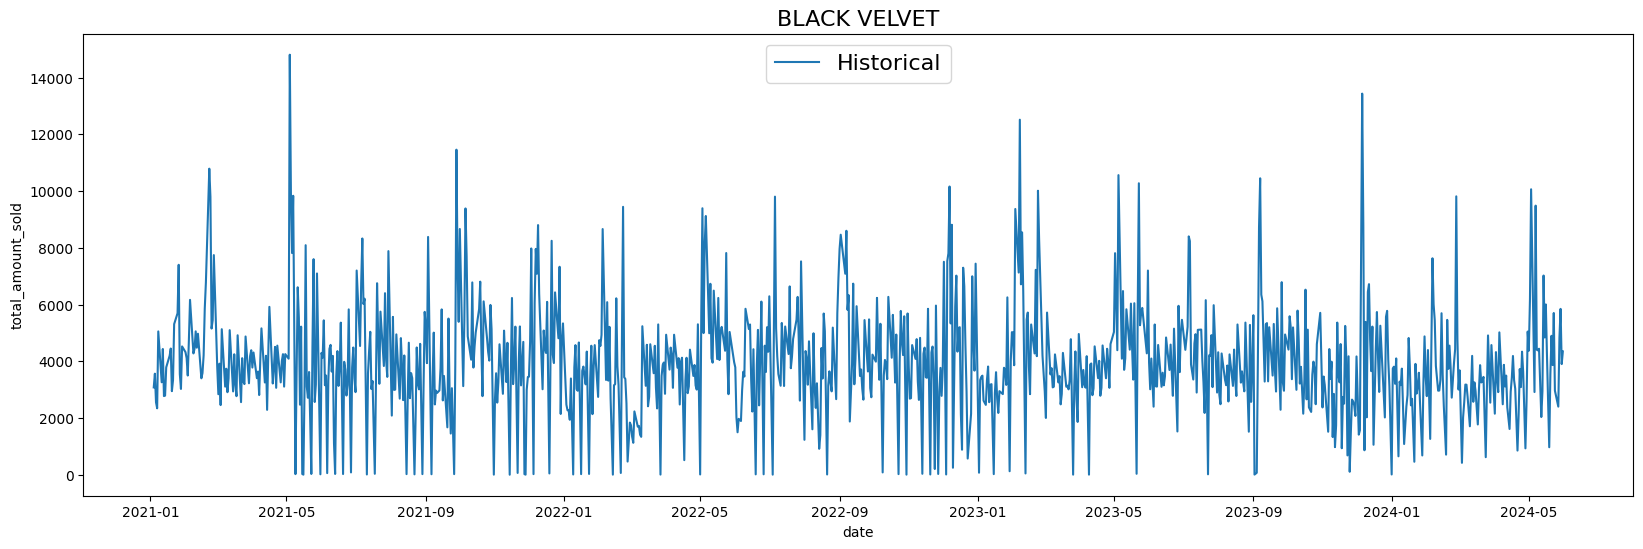

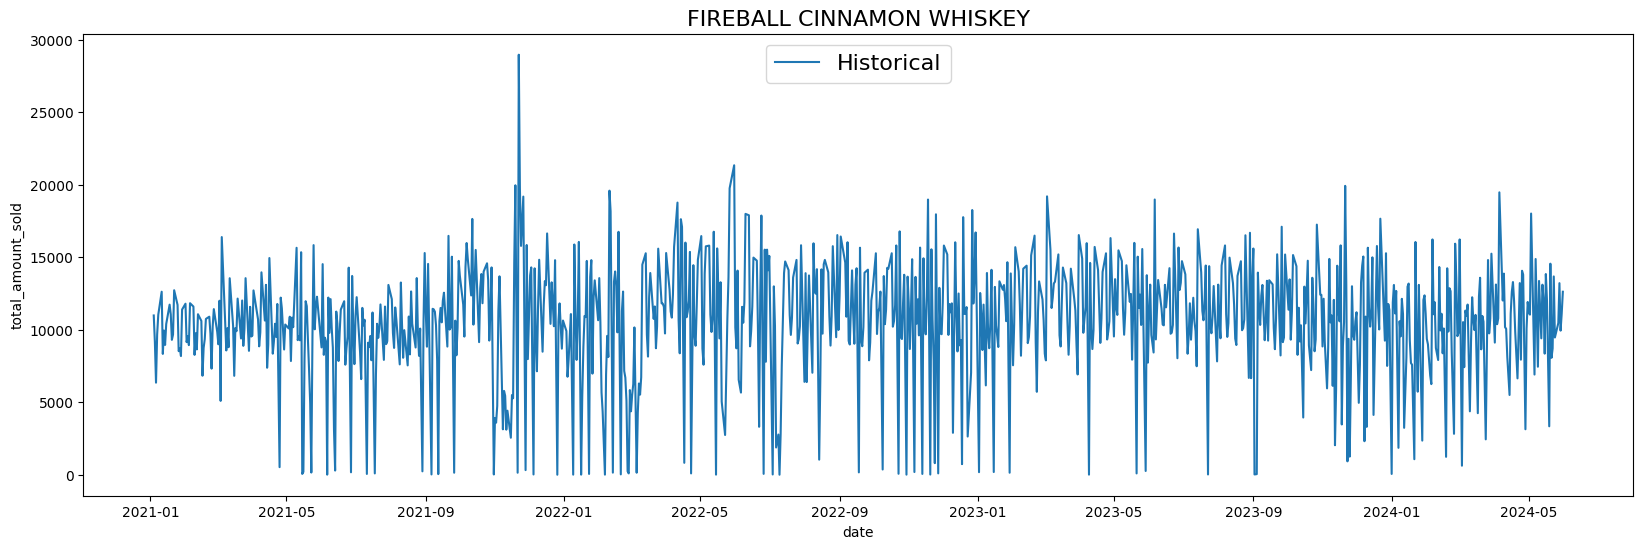

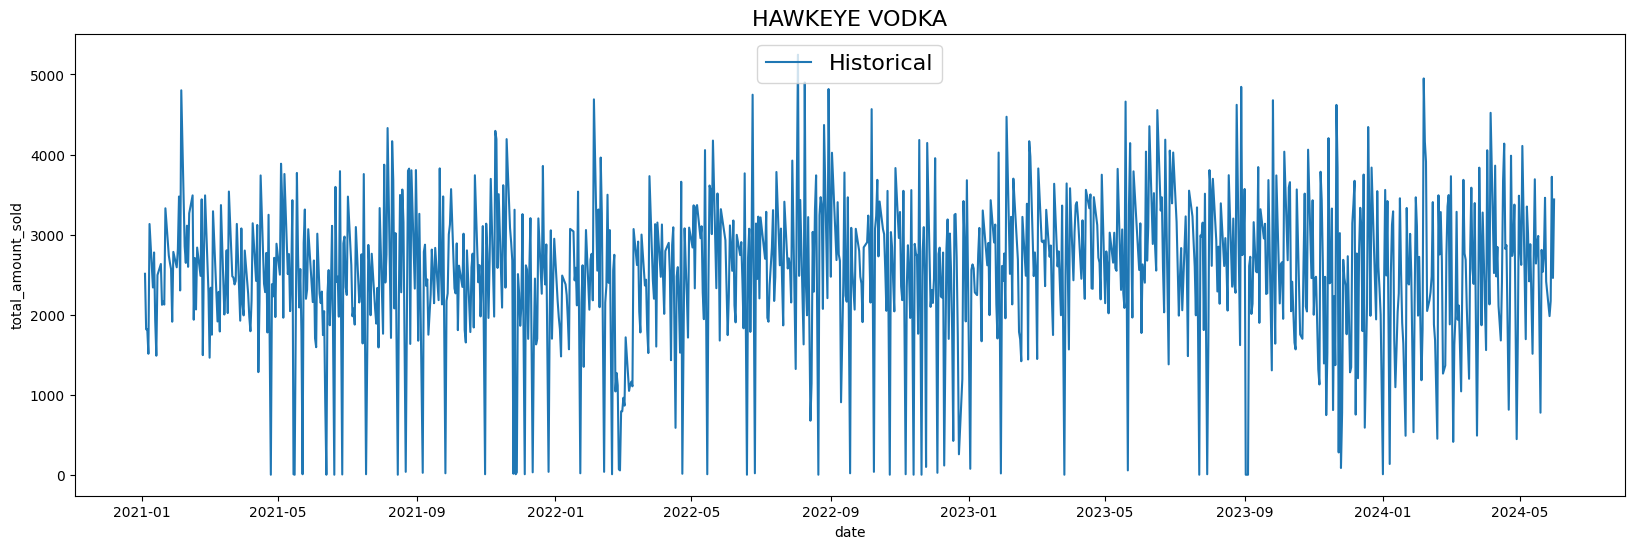

In [ ]:
itemslist = list(df_historical.item_name.unique())

for item in itemslist:

    datah = df_historical[df_historical.item_name==item]
    plot_historical_and_forecast(input_timeseries = datah,
                                 timestamp_col_name = "date",
                                 data_col_name = "total_amount_sold",
                                 forecast_output = None,
                                 actual = None,
                                 title = item)

In [ ]:
# Test stationarity for each item
itemslist = list(df_historical.item_name.unique())
for item in itemslist:
    data = df_historical[df_historical.item_name == item]['total_amount_sold']
    print(f'Stationarity test for {item}:')
    test_stationarity(data)
    print('\n')


Stationarity test for BLACK VELVET:
Results of Dickey-Fuller Test:
Test Statistic                -9.483480e+00
p-value                        3.817353e-16
#Lags Used                     8.000000e+00
Number of Observations Used    9.690000e+02
Critical Value (1%)           -3.437116e+00
Critical Value (5%)           -2.864527e+00
Critical Value (10%)          -2.568361e+00
dtype: float64
The time series is stationary.


Stationarity test for FIREBALL CINNAMON WHISKEY:
Results of Dickey-Fuller Test:
Test Statistic                -1.008894e+01
p-value                        1.135669e-17
#Lags Used                     5.000000e+00
Number of Observations Used    9.690000e+02
Critical Value (1%)           -3.437116e+00
Critical Value (5%)           -2.864527e+00
Critical Value (10%)          -2.568361e+00
dtype: float64
The time series is stationary.


Stationarity test for HAWKEYE VODKA:
Results of Dickey-Fuller Test:
Test Statistic                -8.508209e+00
p-value                      

In [ ]:
# Create ARIMA model
create_arima_model(client, dataset_id, "arima_model")

Model bqmlforecast.arima_model created.


In [ ]:
# Forecast using the model
dfforecast = forecast_model(client, dataset_id, "arima_model", horizon=30, confidence_level=0.9)

In [ ]:
# Define the query to evaluate the ARIMA model
query = f"""
SELECT
  *
FROM
  ML.EVALUATE(MODEL `{dataset_id}.arima_model`),
    (SELECT
    date,
    item_name,
    total_amount_sold
FROM
    {dataset_id}.training_data)
"""

# Execute the query
query_job = client.query(query)

# Fetch the results
results = query_job.result()

# Convert results to a DataFrame
df = results.to_dataframe()

In [ ]:
query = f"""
SELECT
    *
FROM
    {dataset_id}.test_data
"""
dfactual = client.query(query).to_dataframe()

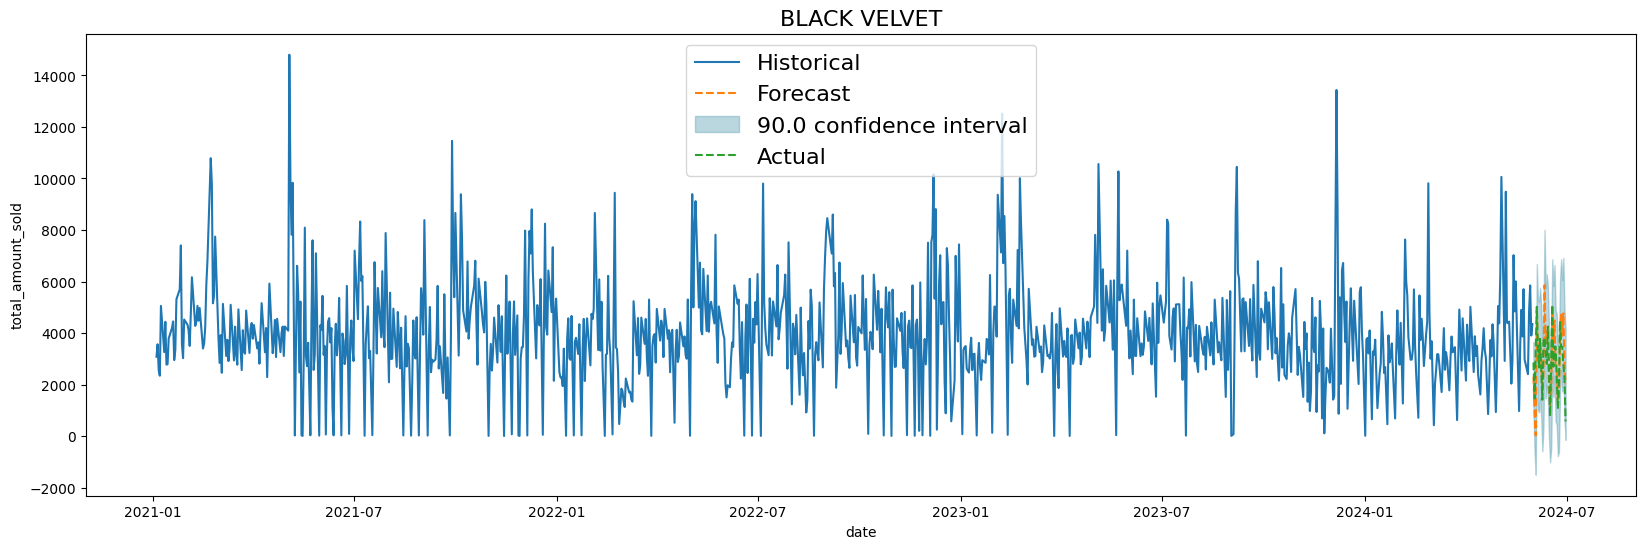

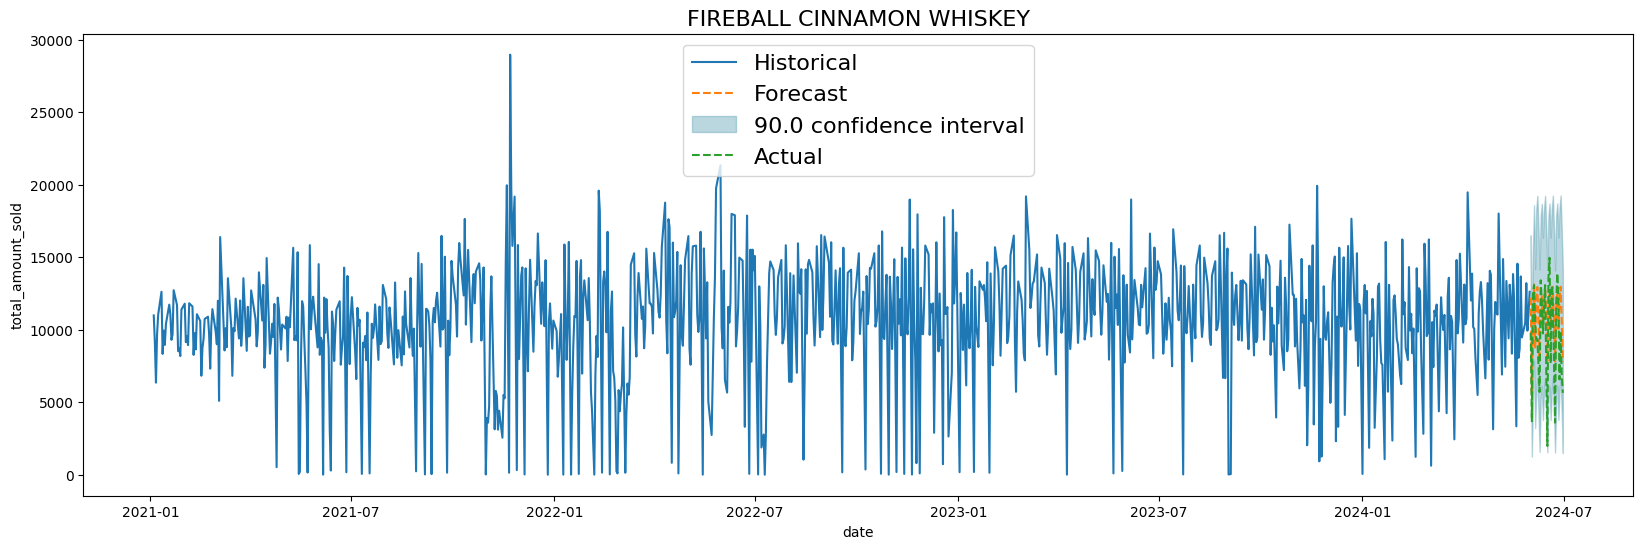

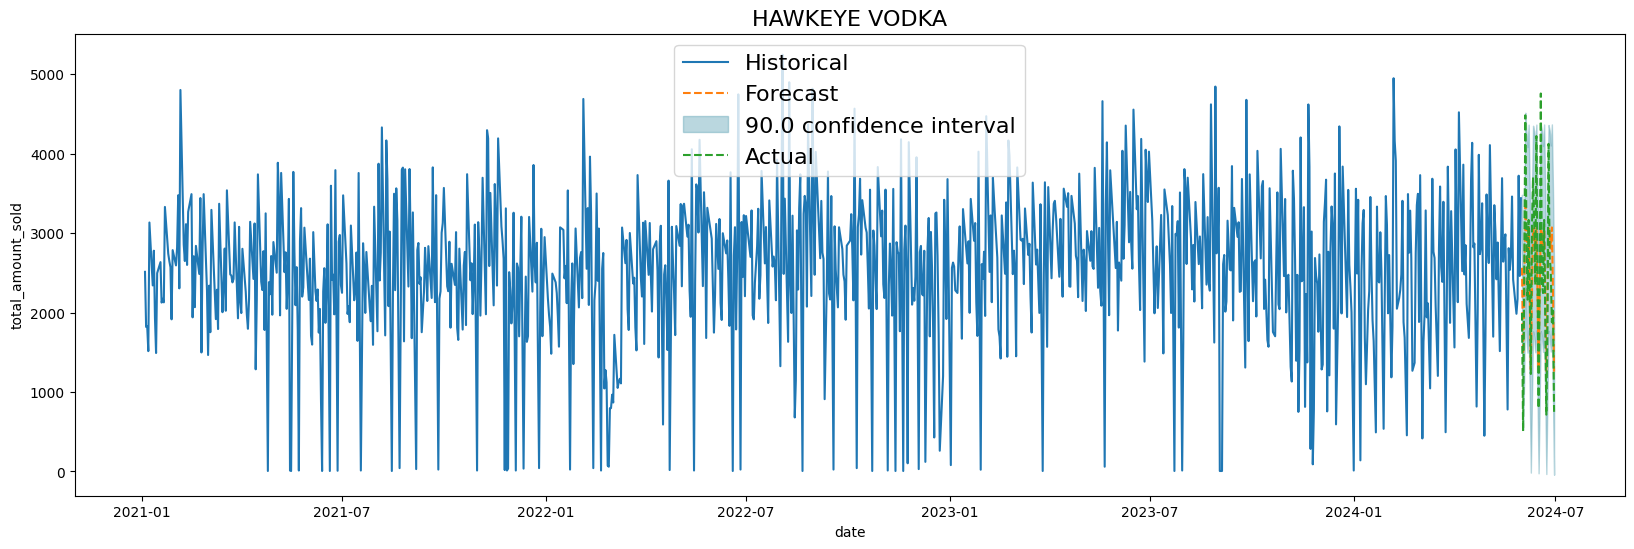

In [ ]:
# Plot historical and forecast data
itemslist = list(df_historical.item_name.unique())
for item in itemslist:
    datah = df_historical[df_historical.item_name==item].copy()
    dataf = dfforecast[dfforecast.item_name==item].copy()
    dataa = dfactual[dfactual.item_name==item].copy()

    plot_historical_and_forecast(input_timeseries = datah,
                                 timestamp_col_name = "date",
                                 data_col_name = "total_amount_sold",
                                 forecast_output = dataf,
                                 actual = dataa,
                                 title = item,
                                 plotstartdate = "2021-01-01")

In [ ]:
# Evaluate the model
print(f'Error metrics for ARIMA Train:')

errors_df = evaluate_model(df, df_historical)
print(errors_df)

print()

print(f'Error metrics for ARIMA Test:')

errors_df = evaluate_model(dfactual, dfforecast)
print(errors_df)



Error metrics for ARIMA Train:
                   item_name          MAE        MAPE           MSE  \
0  FIREBALL CINNAMON WHISKEY  4903.459441  187.762506  4.361031e+07   
1              HAWKEYE VODKA  3213.073728   36.784967  2.708009e+07   
2               BLACK VELVET  2717.156153   43.192832  1.959658e+07   

          RMSE      SMAPE  
0  6603.810361  70.468876  
1  5203.853372  54.989788  
2  4426.802830  44.913606  

Error metrics for ARIMA Test:
                   item_name          MAE       MAPE           MSE  \
0               BLACK VELVET   843.856444  37.244573  1.226847e+06   
1              HAWKEYE VODKA   562.400707  31.043960  4.784633e+05   
2  FIREBALL CINNAMON WHISKEY  2128.155831  35.953973  6.713819e+06   

          RMSE      SMAPE  
0  1107.631394  34.340396  
1   691.710430  25.379915  
2  2591.103765  25.220037  


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw4okpqgn/e5qwwe7r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw4okpqgn/s_9a6dct.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63660', 'data', 'file=/tmp/tmpw4okpqgn/e5qwwe7r.json', 'init=/tmp/tmpw4okpqgn/s_9a6dct.json', 'output', 'file=/tmp/tmpw4okpqgn/prophet_modelzqz6p5vi/prophet_model-20240810124759.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:47:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:47:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw4

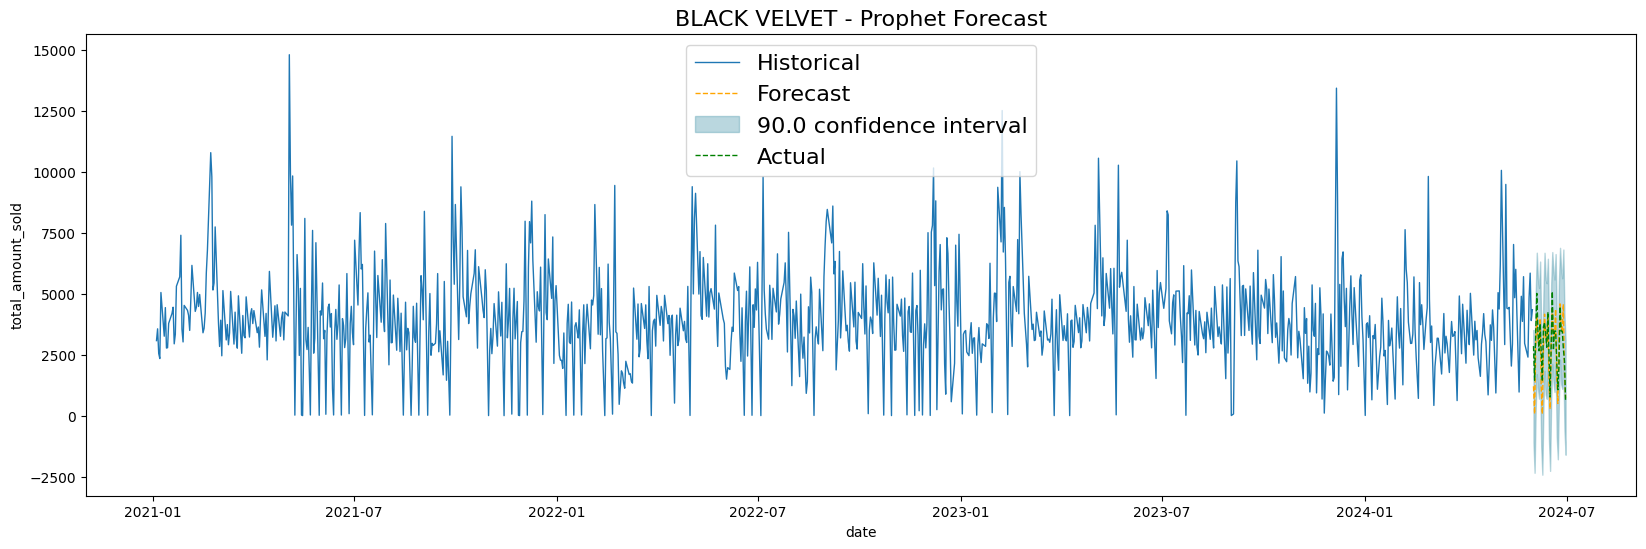

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw4okpqgn/j383yvoi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw4okpqgn/fq49sjqo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36944', 'data', 'file=/tmp/tmpw4okpqgn/j383yvoi.json', 'init=/tmp/tmpw4okpqgn/fq49sjqo.json', 'output', 'file=/tmp/tmpw4okpqgn/prophet_modelrce5hn11/prophet_model-20240810124801.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:48:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:48:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw4

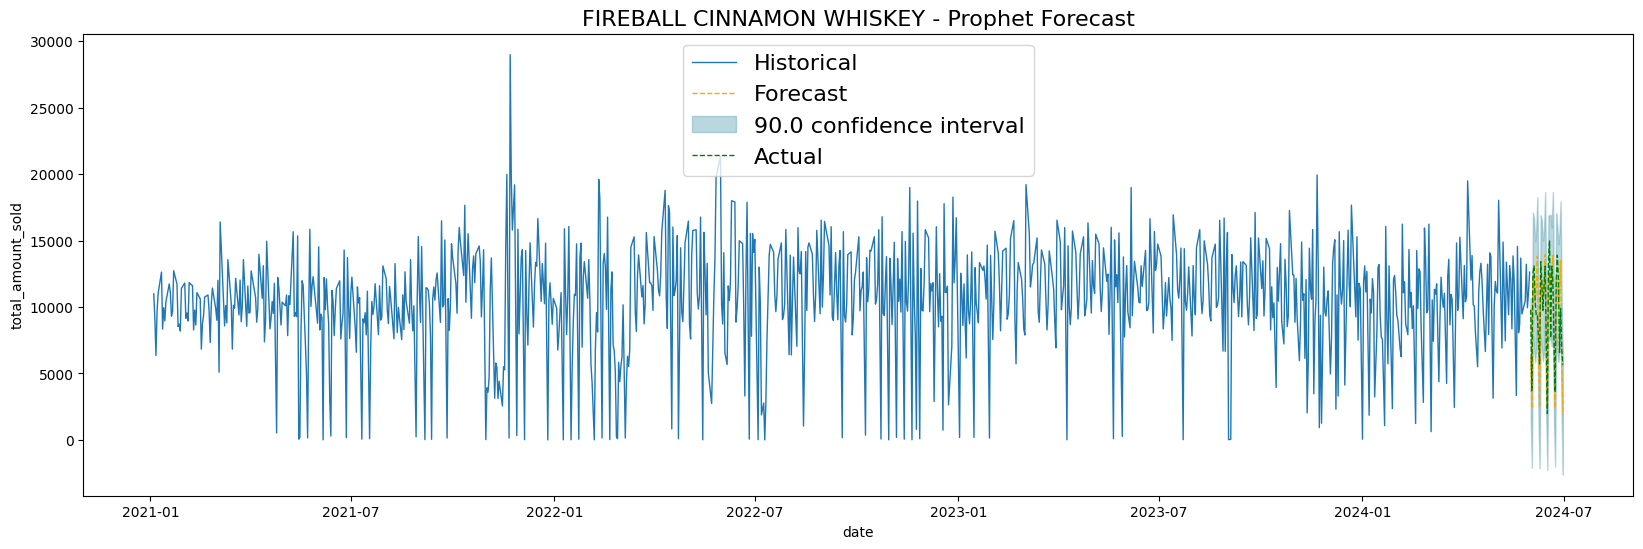

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw4okpqgn/o9_kgx50.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw4okpqgn/1z_mbeom.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20176', 'data', 'file=/tmp/tmpw4okpqgn/o9_kgx50.json', 'init=/tmp/tmpw4okpqgn/1z_mbeom.json', 'output', 'file=/tmp/tmpw4okpqgn/prophet_modeliyoi625k/prophet_model-20240810124804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:48:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:48:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw4

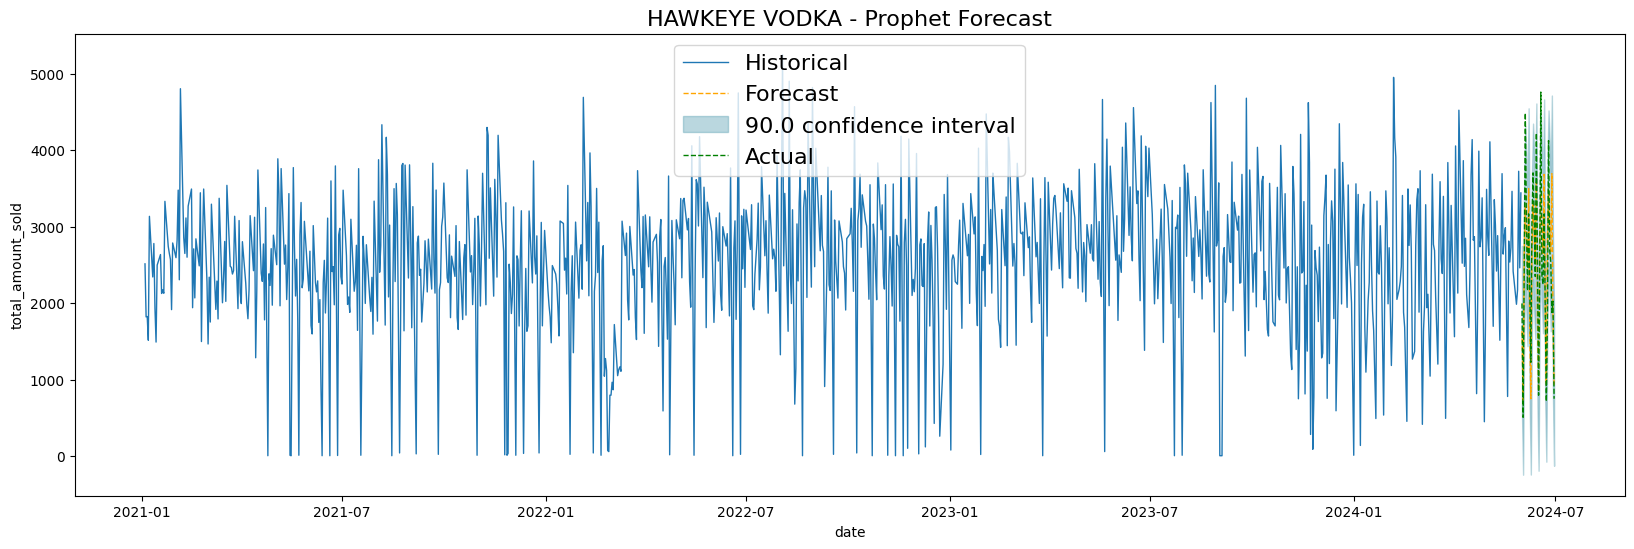

In [ ]:
# Hyperparameter grid for Prophet tuning
param_grid = [
    {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0},
    {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20.0},
    {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 30.0},
    {'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 40.0}
]
prophet_fcast_list = list()
itemslist = list(df_historical.item_name.unique())
for item in itemslist:
    data = df_historical[df_historical.item_name==item][['date', 'total_amount_sold', 'item_name']].copy()
    _, prophet_forecast = tune_prophet_model(data, param_grid)
    prophet_fcast_list.append(prophet_forecast)
    plot_historical_and_forecastprophet(input_timeseries=data,
                                 timestamp_col_name="date",
                                 data_col_name="total_amount_sold",
                                 forecast_output=prophet_forecast,
                                 actual=dfactual[dfactual.item_name==item].copy(),
                                 title=f'{item} - Prophet Forecast',
                                 plotstartdate="2021-01-01")
prophet_fcast=pd.concat(prophet_fcast_list)

In [ ]:
# Evaluate the best Prophet model
errors_df_prophet = evaluate_profetmodel(df_historical, prophet_fcast)
print(f'Error metrics for Prophet Train:')
print(errors_df_prophet)
print()
errors_df_prophet = evaluate_profetmodel(dfactual, prophet_fcast)
print(f'Error metrics for Prophet Test:')
print(errors_df_prophet)

Error metrics for Prophet Train:
                   item_name          MAE        MAPE           MSE  \
0               BLACK VELVET  3077.988807  373.417378  1.883524e+07   
1  FIREBALL CINNAMON WHISKEY  5633.911787  177.046165  4.702475e+07   
2              HAWKEYE VODKA  3381.846669  514.255477  2.486206e+07   

          RMSE      SMAPE  
0  4339.958188  59.737458  
1  6857.459576  80.250762  
2  4986.186614  68.891833  

Error metrics for Prophet Test:
                   item_name          MAE        MAPE           MSE  \
0               BLACK VELVET  2685.783244   93.685137  1.928236e+07   
1              HAWKEYE VODKA  2816.732310  119.691257  2.163518e+07   
2  FIREBALL CINNAMON WHISKEY  5430.034791   56.693579  4.120863e+07   

          RMSE      SMAPE  
0  4391.168457  54.097490  
1  4651.363410  57.560118  
2  6419.394887  86.724121  


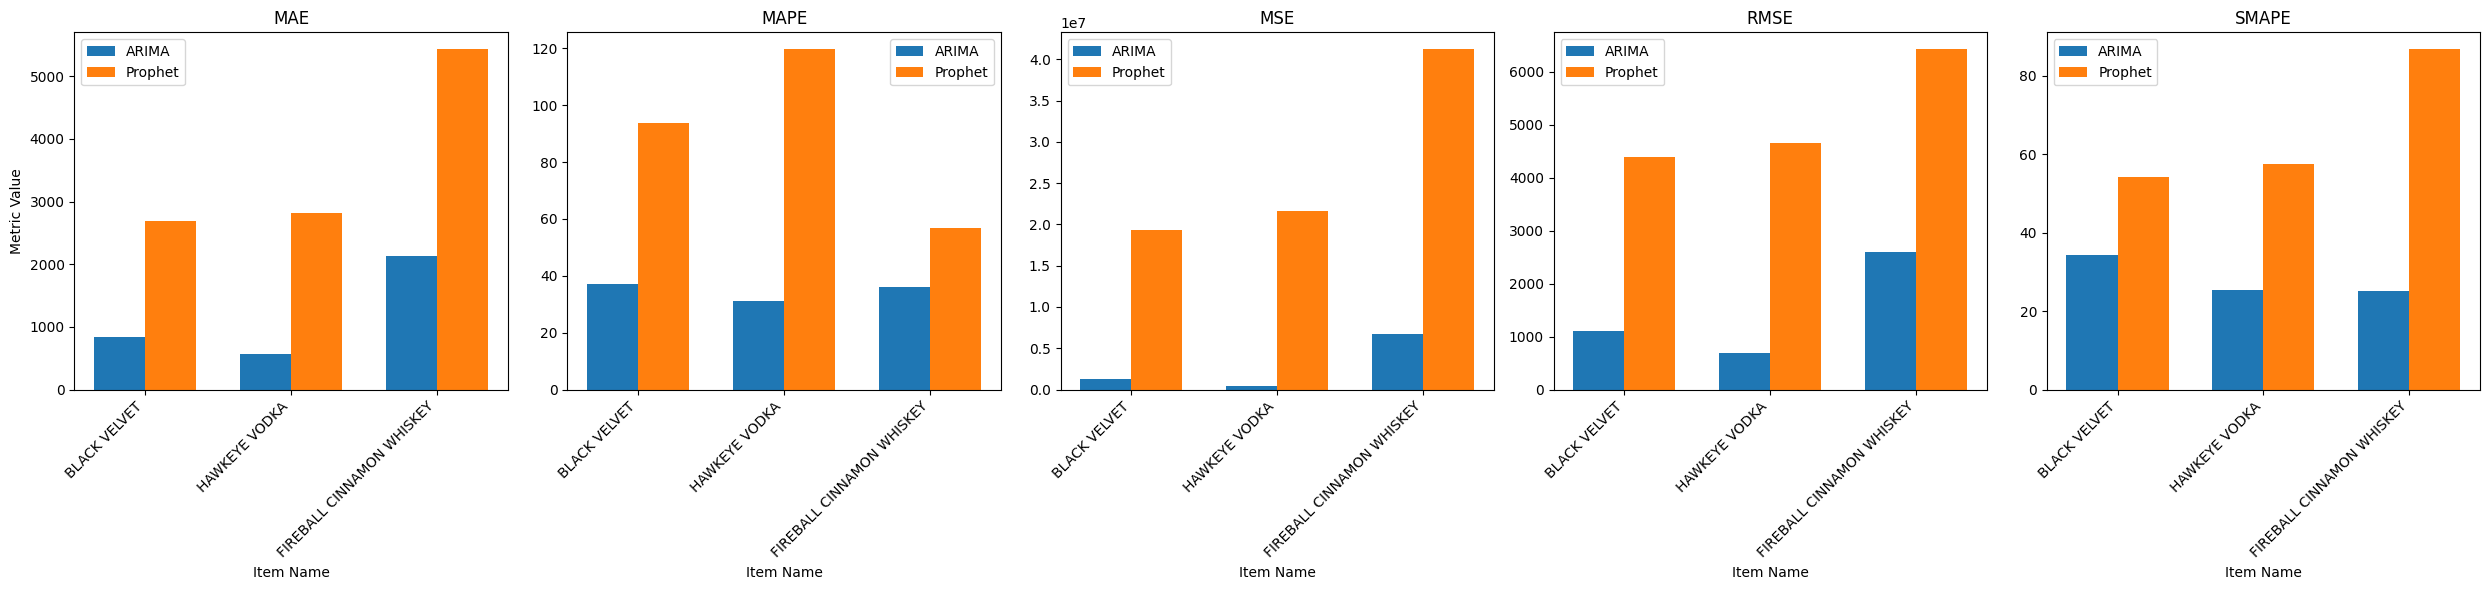

In [ ]:
# Combine ARIMA and Prophet evaluation metrics for comparison
metrics_comparison = pd.merge(errors_df, errors_df_prophet, on='item_name', suffixes=('_ARIMA', '_Prophet'))
# Plot the metrics comparison
metrics = ['MAE', 'MAPE', 'MSE', 'RMSE', 'SMAPE']
fig, axs = plt.subplots(nrows=1, ncols=len(metrics), figsize=(25, 6), sharey=False)

bar_width = 0.35
index = range(len(metrics_comparison['item_name']))

for i, metric in enumerate(metrics):
    axs[i].bar(index, metrics_comparison[f'{metric}_ARIMA'], bar_width, label='ARIMA')
    axs[i].bar([p + bar_width for p in index], metrics_comparison[f'{metric}_Prophet'], bar_width, label='Prophet')

    axs[i].set_title(metric)
    axs[i].set_xlabel('Item Name')
    axs[i].set_xticks([p + bar_width / 2 for p in index])
    axs[i].set_xticklabels(metrics_comparison['item_name'], rotation=45, ha='right')
    axs[i].legend()

axs[0].set_ylabel('Metric Value')

plt.tight_layout()
plt.show()

In [ ]:
# Realizando o teste t para comparar MAE, MAPE, MSE, RMSE e SMAPE entre ARIMA e Prophet
metrics = ['MAE', 'MAPE', 'MSE', 'RMSE', 'SMAPE']
t_test_results = {}

for metric in metrics:
    t_stat, p_value = stats.ttest_rel(metrics_comparison[f'{metric}_ARIMA'], metrics_comparison[f'{metric}_Prophet'])

    # Verificar se a diferença é significativa
    significance = 'Significant' if p_value < 0.05 else 'Not Significant'

    t_test_results[metric] = {
        't_stat': t_stat,
        'p_value': p_value,
        'Significance': significance,
    }

# Convertendo os resultados para DataFrame para exibir
t_test_df = pd.DataFrame(t_test_results).T
print(t_test_df)

          t_stat   p_value     Significance
MAE    -5.675036  0.029675      Significant
MAPE   -2.818482  0.106204  Not Significant
MSE    -4.871907  0.039643      Significant
RMSE  -17.830048  0.003131      Significant
SMAPE  -3.055381  0.092497  Not Significant


In [ ]:
# Call the function to create the training data table and train the ARIMA model
# The function returns a success message upon completion
result = create_and_train_arima_model(PROJECT_ID, dataset_id, 'training_data', 'arima_model')

# Print the success message to confirm that the ARIMA model was created and trained
print(result)


ARIMA model created and trained successfully.


In [ ]:
# Call the function to create the forecast table, insert forecast data, export the data to Google Cloud Storage,
# and return both a success message and the forecast data as a DataFrame.
# Note: Billing needs to be enabled for this project to run BigQuery operations and export data to Google Cloud Storage.

message, result_df = create_and_insert_forecast_data(PROJECT_ID, dataset_id, 'forecast', 'arima_model', f'{BUCKET_URI}/arima_forecast*.csv')

# Print the success message to confirm that the forecast data table was created, data was inserted,
# and the data was exported successfully.
print(message)

# Optionally, you can print the first few rows of the DataFrame to inspect the data
print(result_df.head())

## Clean up



In [ ]:
# Set dataset variable to the ID of the dataset to fetch.
dataset = f"{PROJECT_ID}.{dataset_id}"

# Use the delete_contents parameter to delete a dataset and its contents.
# Use the not_found_ok parameter to not receive an error if the dataset has already been deleted.
client.delete_dataset(
    dataset_id, delete_contents=True, not_found_ok=True
)  # Make an API request.

print("Deleted dataset '{}'.".format(dataset_id))

# Delete Cloud Storage objects that were created
delete_bucket = True  # Set True for deletion
if delete_bucket:
    ! gsutil -m rm -r $BUCKET_URI

Deleted dataset 'bqmlforecast'.
Removing gs://your-bucket-name-bqmlproject/...
